In [2]:
import numpy as np
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import *
import qiskit
import matplotlib.pyplot as plt

In [3]:
num_qubits = 32

In [4]:
def create_random_states():

    alice_state = np.random.randint(0, 2, size=num_qubits)
    bob_basis = np.random.randint(0, 2, size=num_qubits)
#    print(f"Alice's State:\t {np.array2string(alice_state, separator='')}")
#    print(f"Bob's Basis:\t {np.array2string(bob_basis, separator='')}")
    
    return alice_state, bob_basis

In [5]:
# function to define the circuit for an exchange of bit string
def make_b92_circ(enc_state, meas_basis, noise_prob):
    
    num_qubits = len(enc_state)

    b92 = QuantumCircuit(num_qubits)

    for index in range(len(enc_state)):
        if enc_state[index] == 1:
            b92.h(index)

    b92.barrier()
    
    noise = []

    for index in range(len(enc_state)):
        if np.random.random() <= noise_prob:
            b92.y(index)
            noise.append(1)
        else:
            noise.append(0)
            
            
    #print(f"Noise:\t\t {np.array2string(np.array(list(noise), dtype=int), separator='')}")
    
    b92.barrier()  

    for index in range(len(meas_basis)):
        if meas_basis[index] == 1:
            b92.h(index)

    # Do not change below this line
    b92.measure_all()
    return b92

In [6]:
def b92_sifting(enc_state, meas_basis, meas_result):
    
    num_qubits = len(enc_state)
    
    sender_key = ''
    receiver_key = ''
    
    for i in range(len(meas_result)):
      if meas_result[i] == '1':
        sender_key+=str(enc_state[i])
        receiver_key+=str((meas_basis[i]+1)%2)
        
    return (sender_key, receiver_key)

In [7]:
iterations = 200
noise_prob = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
key_rate_arr = []

print(f"Initial key length = {num_qubits}")
print(f"\n")

for noise in noise_prob:

    key_list = []
    #print(f"For noise of {noise} all the values are: ")
    for index in range (0,iterations):

        alice_state, bob_basis = create_random_states()

        #Alice sends the bits to Bob but Eve eavesdrops in between
        b92_circ = make_b92_circ(alice_state, bob_basis, noise)

        #final result got by Eve after measurement
        bob_res = execute(
                b92_circ.reverse_bits(),
                backend=QasmSimulator(),
                shots=1, 
            ).result().get_counts().most_frequent()

    #   print(f"Bob's result:\t [{bob_res}]")
        # key sifting takes place to get the final key to be used
        alice_key, bob_key = b92_sifting(alice_state, bob_basis, bob_res)

    #     print(f"Alice's final key: \t{alice_key}")
    #     print(f"Bob's final key: \t{bob_key}")
        key_list.append(bob_key)
        
    #   print(f"Final key: {bob_key} ")
    
    #print(key_list)
    
    avg_key_length = sum( map( len, key_list))/ len(key_list)
    key_rate_arr.append(avg_key_length/num_qubits)
    
    #print(f"Final average key length after {iterations} iterations =  {avg_key_length}")
    #print(f"Key rate: {avg_key_length/num_qubits}")
    #print(f"\n")
    
print(f"Noise Probability:\t {noise_prob}")
print(f"The key rate:\t\t{key_rate_arr}")

Initial key length = 32


Noise Probability:	 [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
The key rate:		[0.25453125, 0.305, 0.34578125, 0.400625, 0.44171875, 0.49890625, 0.550625, 0.5996875, 0.6621875, 0.71171875, 0.7503125]


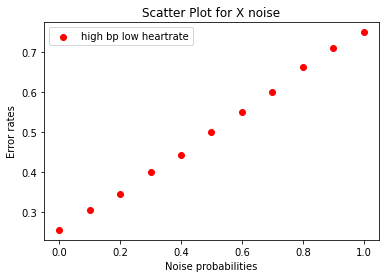

In [8]:
plt.scatter(noise_prob,key_rate_arr, label="high bp low heartrate",color="r")
plt.title("Scatter Plot for X noise")
plt.xlabel("Noise probabilities")
plt.ylabel("Error rates")
plt.legend()
plt.show()